In [132]:
import torch 
import torchvision

In [133]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [134]:
n_epochs = 2
batch_size_train = 128
batch_size_test = 128
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [135]:
train_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('~/Downloads/', train=True, download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                              (0.1307,), (0.3081,))
                          ])),
batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('~/Downloads/', train=False, download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                              (0.1307,), (0.3081,))
                          ])),
batch_size=batch_size_test, shuffle=True)

In [136]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [137]:
example_data.shape

torch.Size([128, 1, 28, 28])

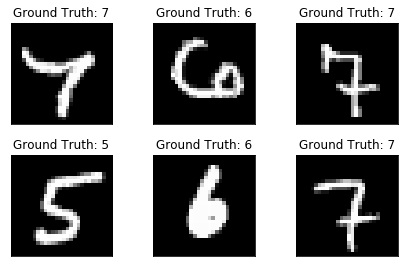

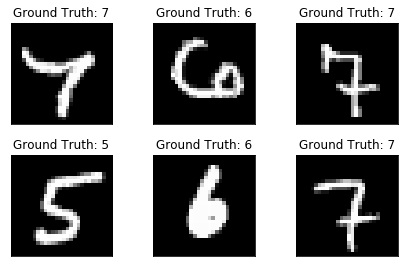

In [138]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title('Ground Truth: {}'.format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [139]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [140]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = x.view(-1,320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
        
        

In [141]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [142]:
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [143]:
!nvidia-smi

Tue Feb 25 23:31:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P3    N/A /  N/A |    675MiB /  4040MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [144]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [145]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                 epoch, batch_idx * len(data), len(train_loader.dataset),
                 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './output/model.pth')
            torch.save(optimizer.state_dict(), './output/optimizer.pth')

In [146]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [147]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/karan/Downloads/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [148]:
%%time
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/karan/.virtualenvs/kj/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331745
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.307435
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.289412
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.269871
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.246026
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.213428
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.109425
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.109599
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.923808
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.923711
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.786777
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.719109
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.589835
Train Epoch: 1 [16640/60000 (28%)]	Loss: 1.533771
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.433489
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.392532
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.336394
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.185301
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.257516
Train Epoc